In [107]:
import pandas as pd

# loading the dataset
x_train = pd.read_csv('CompleteDataset/x_train_all.csv')
y_train = pd.read_csv('CompleteDataset/y_train_all.csv')
x_test = pd.read_csv('CompleteDataset/x_test_all.csv')
y_test = pd.read_csv('CompleteDataset/y_test_all.csv')

In [108]:
# performs z-normalization on our dataset

# normalize x_train
mean=x_train.mean()
std=x_train.std()
x_train_norm=(x_train-mean)/std

# normalize x_test
mean=x_test.mean()
std=x_test.std()
x_test_norm=(x_test-mean)/std

In [109]:
from sklearn.ensemble import IsolationForest

# uses isolation forest algorithm to find outliers

feature_names = [f'{str(col)}' for col in x_train.columns]
x_train_norm.columns = feature_names

x_train_norm_copy = x_train_norm.copy()
contamination = 0.41
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(x_train_norm_copy)

outlier_indices = x_train_norm_copy.index[outliers == -1]

x_train_no_outliers_norm = x_train_norm_copy.drop(outlier_indices)
x_train_no_outliers_norm.to_csv('x_train_no_outliers_norm.csv')

outlier_indices_df = pd.DataFrame({'outlier_index_norm': outlier_indices})
outlier_indices_df.to_csv('outlier_indices_norm.csv', index=False)

In [110]:
# applies outlier mining to y train

# loads the indices to be removed from the dataset
indices_to_remove_norm = pd.read_csv('outlier_indices_norm.csv')

# removes outliers found after normalizing from y train
y_train_filtered_outlier_norm = y_train[~y_train.index.isin(indices_to_remove_norm['outlier_index_norm'])]

# saves to csv for future use
y_train_filtered_outlier_norm.to_csv('y_train_filtered_outlier_norm.csv')

In [111]:
# load y train without outliers
y_train_filtered_outlier_norm=pd.read_csv('y_train_filtered_outlier_norm.csv')

# drop previous indices
y_train_filtered_outlier_norm.drop('Unnamed: 0',axis=1, inplace=True)

In [112]:
from sklearn.ensemble import IsolationForest

# uses isolation forest algorithm to find outliers

feature_names = [f'{str(col)}' for col in x_test.columns]
x_test_norm.columns = feature_names

x_test_norm_copy = x_test_norm.copy()
contamination = 0.41
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(x_test_norm_copy)

outlier_indices = x_test_norm_copy.index[outliers == -1]

x_test_no_outliers_norm = x_test_norm_copy.drop(outlier_indices)
x_test_no_outliers_norm.to_csv('x_test_no_outliers_norm.csv')

outlier_indices_df_test = pd.DataFrame({'outlier_index_norm_test': outlier_indices})
outlier_indices_df_test.to_csv('outlier_indices_norm_test.csv', index=False)

In [113]:
# applies outlier mining to y test

# loads the indices to be removed from the dataset
indices_to_remove_norm_test = pd.read_csv('outlier_indices_norm_test.csv')

# removes outliers found after normalizing from y train
y_test_filtered_outlier_norm = y_test[~y_test.index.isin(indices_to_remove_norm_test['outlier_index_norm_test'])]

# saves to csv for future use
y_test_filtered_outlier_norm.to_csv('y_test_filtered_outlier_norm.csv')

In [114]:
# load y train without outliers
y_test_filtered_outlier_norm=pd.read_csv('y_test_filtered_outlier_norm.csv')

# drop previous indices
y_test_filtered_outlier_norm.drop('Unnamed: 0',axis=1, inplace=True)

In [135]:
# functions for getting performance metrics

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    auc
)

# runs the given fitted classifier with the given test data, outputs some performance metrics
def get_metrics_simple(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")

    # plotting the confusion matrix 
    out=ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    out.plot()
    plt.show()
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)

# fits and runs the given classifier with the given train and test data, outputs performance metrics
def get_metrics(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    y_pred_probs = clf.predict_proba(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")
    # finding the roc
    Y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
    roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
    # plotting the AUC graph
    auc_val = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    # plotting the confusion matrix 
    out=ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    out.plot()
    plt.show()
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)
    # print("False Positive Rate:", fpr)
    print("Area under ROC curve:", roc)
    print("Confusion Matrix:\n", conf_matrix)

In [116]:
# return performance metrics as an array
def get_metrics_array(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    # y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    y_pred_probs = clf.predict_proba(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")
    # finding the roc
    Y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
    # plotting the AUC graph
    # print("Option: ", name)
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % roc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve')
    # plt.legend(loc="lower right")
    # plt.show()
    # # plotting the confusion matrix 
    # out = ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    # out.plot()
    # plt.show()
    # print("\n\n")
    return [accuracy, f1, precision, recall, roc]

In [117]:
def multi_get_metrics(names, clfs, x_test, y_test):
    results = {
        "name": [],
        "accuracy": [],
        "f1": [],
        "precision": [],
        "recall": [],
        "fpr": [],
        "roc": [],
        "confusion_matrix": []
    }
    for i in range(len(names)):
        clf = clfs[i]
        name = names[i]
        # transform pandas dataset to a 1d numpy array
        # y_test = y_test.to_numpy().ravel()

        y_pred = clf.predict(x_test)
        y_pred_probs = clf.predict_proba(x_test)
        # finding the accuracy
        accuracy = accuracy_score(y_test,y_pred )
        # finding the f1
        f1 = f1_score(y_pred, y_test, average="weighted")
        # finding the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        # finding the precision
        precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
        # finding the recall
        recall = recall_score(y_test, y_pred, average="weighted")
        # finding the roc
        Y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

        fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
        # plotting the AUC graph
        # print("Option: ", name)
        # plt.figure()
        # plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % roc)
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('ROC Curve')
        # plt.legend(loc="lower right")
        # plt.show()
        # # plotting the confusion matrix 
        # out = ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
        # out.plot()
        # plt.show()
        # print("\n\n")
        results["name"].append(name)
        results["accuracy"].append(accuracy)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["fpr"].append(fpr)
        results["roc"].append(roc)
        results["confusion_matrix"].append(conf_matrix)
    results_df = pd.DataFrame(results)
    results_df.drop(columns=["fpr", "confusion_matrix"], inplace=True)
    return results_df

    

In [118]:
# functions for cross-validation and 

import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import(
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)

# fits and runs the given classifier with the given train data and cross validation, outputs some performance metrics
def get_cross_val_metrics_simple(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    y_train = y_train.to_numpy().ravel()

    # Perform 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validation accuracy scores
    print("Cross-validation accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("Accuracy standard deviation:", cv_scores.std())

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightgreen')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

# fits and runs the given classifier with the given train data and cross validation, outputs performance metrics
def get_cross_val_metrics(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    # y_train = y_train.to_numpy().ravel()

    # Perform 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validation accuracy scores
    print("Cross-validation accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("Accuracy standard deviation:", cv_scores.std())

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightgreen')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

    # Get predicted y_train for each fold
    y_pred = cross_val_predict(clf, x_train, y_train, cv=cv)

    # Compute overall precision, recall, F1 score, and support (unused)
    precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average='macro')

    # Print overall metrics
    print("Overall Precision:", precision)
    print("Overall Recall:", recall)
    print("Overall F1 Score:", f1)

    # Initialize variables to store overall metrics and confusion matrix
    overall_conf_matrix = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))

    # Loop over each fold
    for i, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
        X_train, X_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
        Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Fit the classifier
        clf.fit(X_train, Y_train)

        # Predict on the test set
        y_fold_pred = clf.predict(X_test)

        # Compute and plot confusion matrix
        conf_matrix = confusion_matrix(Y_test, y_fold_pred)
        overall_conf_matrix += conf_matrix

    # Calculate and print average confusion matrix
    y_train_annot = list(np.unique(np.array(y_train)))
    avg_conf_matrix = overall_conf_matrix / 10
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", xticklabels=y_train_annot, yticklabels=y_train_annot)
    plt.title("Average Confusion Matrix")
    plt.xlabel("Predicted y_train")
    plt.ylabel("Actual y_train")
    plt.show()

    X = x_train.values  # Convert DataFrame to NumPy array
    y = y_train.values  # Convert DataFrame to NumPy array

    y_scores = np.zeros((len(y), len(np.unique(y))))

    for train, test in cv.split(X, y):
        clf.fit(X[train], y[train])
        y_scores[test] = clf.predict_proba(X[test])

    # Compute overall ROC-AUC score
    roc_auc = roc_auc_score(label_binarize(y, classes=np.unique(y)), y_scores, average='macro')

    # Print overall ROC-AUC score
    print("Overall ROC-AUC:", roc_auc)

def plot_learning_curve(clf, x_train, y_train):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores, val_scores = [], []

    for size in train_sizes:
        sample_size = int(len(x_train) * size)
        train_score = np.mean(cross_val_score(clf, x_train[:sample_size], y_train[:sample_size], cv=10))
        train_scores.append(train_score)
        val_score = np.mean(cross_val_score(clf, x_train, y_train, cv=10))
        val_scores.append(val_score)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(x_train), train_scores, 'o-', color="red", label="Training score")
    plt.plot(train_sizes * len(x_train), val_scores, 'o-', color="green", label="Cross-validation score")

    plt.title("Decision Tree Learning Curve")
    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    print("Average Training Score:", sum(train_scores)/10 )
    print("Average Cross-Validation Score:",sum(val_scores)/10)

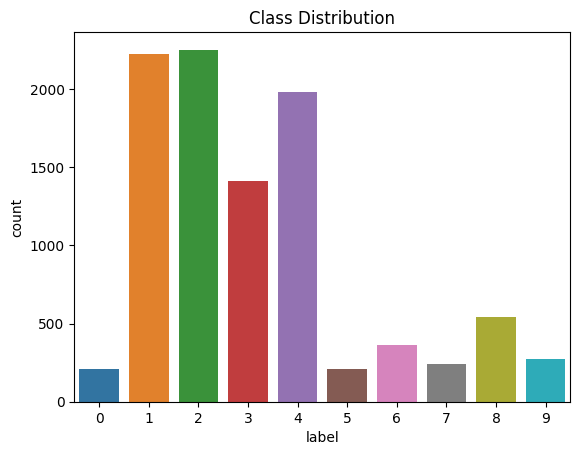

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# makes a bar graph counting the number of instances for each label
sns.countplot(data=y_train, x='0')
plt.xlabel("label")
plt.title('Class Distribution')
plt.show()

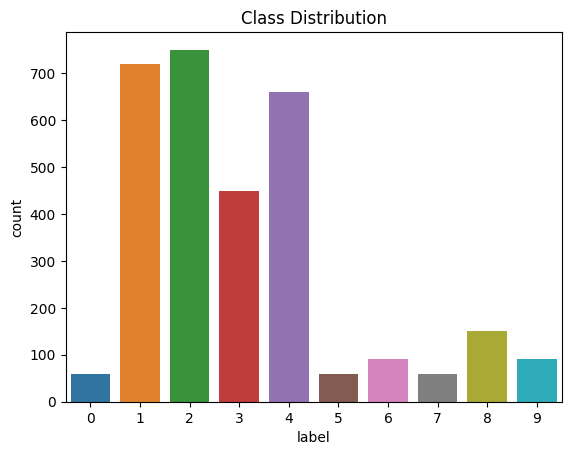

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# makes a bar graph counting the number of instances for each label
sns.countplot(data=y_test, x='0')
plt.xlabel("label")
plt.title('Class Distribution')
plt.show()

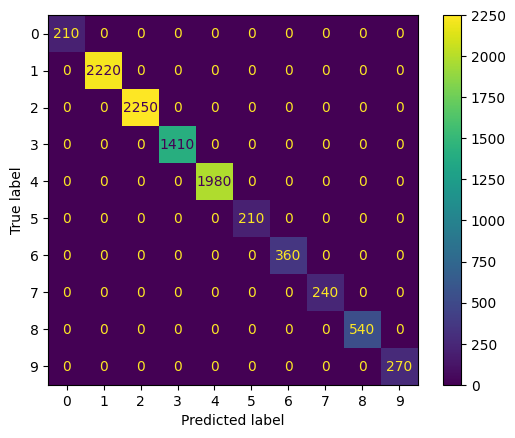

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall/Sensitivity/True Positive Rate: 1.0


In [121]:
# run a linear svm classifier on training set to check for linear separability

from sklearn.svm import SVC

svm = SVC(kernel="linear", random_state=42)
svm.fit(x_train, y_train.to_numpy().ravel())
get_metrics_simple(svm, x_train, y_train)

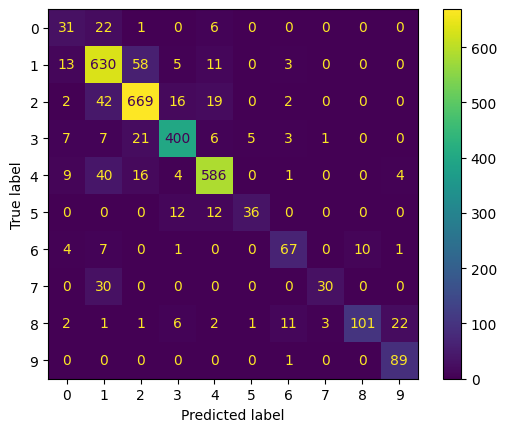

Accuracy: 0.8540453074433657
F1 Score: 0.8552576711876156
Precision: 0.8579061583577202
Recall/Sensitivity/True Positive Rate: 0.8540453074433657


In [95]:
# linear svm classifier on validation set
get_metrics_simple(svm, x_test, y_test)

In [122]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import (
    LogisticRegression,
    Perceptron,
)

perceptron_clf = Perceptron(random_state=42, class_weight="balanced")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
perceptron_clf_calibrated = CalibratedClassifierCV(perceptron_clf, cv=cv)

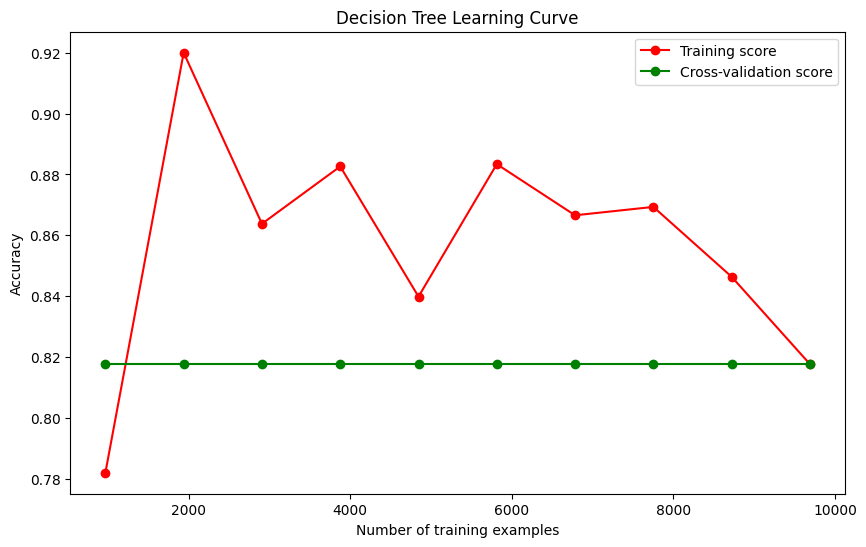

Average Training Score: 0.8571546454618719
Average Cross-Validation Score: 0.8176470588235294


In [123]:
# learning curve for perceptron
perceptron_test = Perceptron(random_state=42, class_weight="balanced")
plot_learning_curve(perceptron_test, x_train, y_train.to_numpy().ravel())

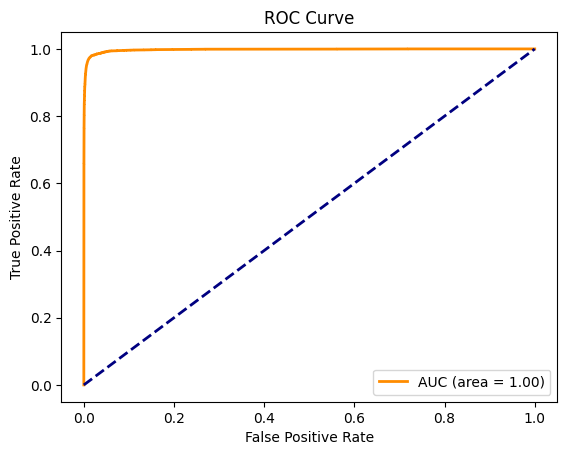

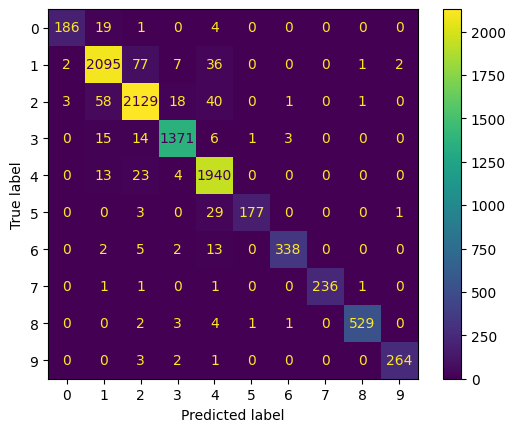

Accuracy: 0.956140350877193
F1 Score: 0.956217842264224
Precision: 0.9565995641836605
Recall/Sensitivity/True Positive Rate: 0.956140350877193
False Positive Rate: [0.         0.         0.         ... 0.71844972 0.71844972 1.        ]
Area under ROC curve: 0.9950319461945567
Confusion Matrix:
 [[ 186   19    1    0    4    0    0    0    0    0]
 [   2 2095   77    7   36    0    0    0    1    2]
 [   3   58 2129   18   40    0    1    0    1    0]
 [   0   15   14 1371    6    1    3    0    0    0]
 [   0   13   23    4 1940    0    0    0    0    0]
 [   0    0    3    0   29  177    0    0    0    1]
 [   0    2    5    2   13    0  338    0    0    0]
 [   0    1    1    0    1    0    0  236    1    0]
 [   0    0    2    3    4    1    1    0  529    0]
 [   0    0    3    2    1    0    0    0    0  264]]


In [124]:
# training set without 10-fold cross-valiation
perceptron_clf_calibrated.fit(x_train, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_train, y_train)

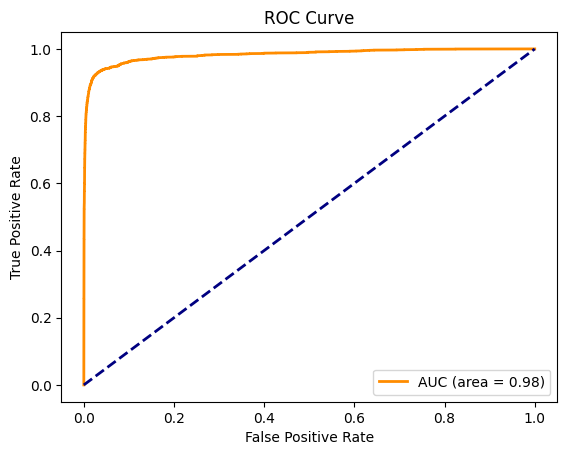

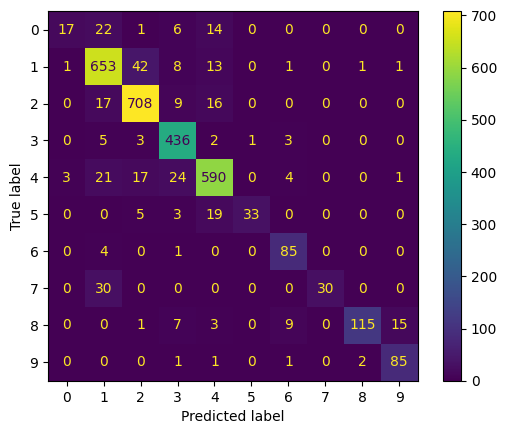

Accuracy: 0.8906148867313916
F1 Score: 0.895978843248507
Precision: 0.8928907465423661
Recall/Sensitivity/True Positive Rate: 0.8906148867313916
False Positive Rate: [0.         0.         0.         ... 0.82621359 0.82621359 1.        ]
Area under ROC curve: 0.978877446567781
Confusion Matrix:
 [[ 17  22   1   6  14   0   0   0   0   0]
 [  1 653  42   8  13   0   1   0   1   1]
 [  0  17 708   9  16   0   0   0   0   0]
 [  0   5   3 436   2   1   3   0   0   0]
 [  3  21  17  24 590   0   4   0   0   1]
 [  0   0   5   3  19  33   0   0   0   0]
 [  0   4   0   1   0   0  85   0   0   0]
 [  0  30   0   0   0   0   0  30   0   0]
 [  0   0   1   7   3   0   9   0 115  15]
 [  0   0   0   1   1   0   1   0   2  85]]


In [125]:
# testing set
perceptron_clf_calibrated.fit(x_train, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_test, y_test)

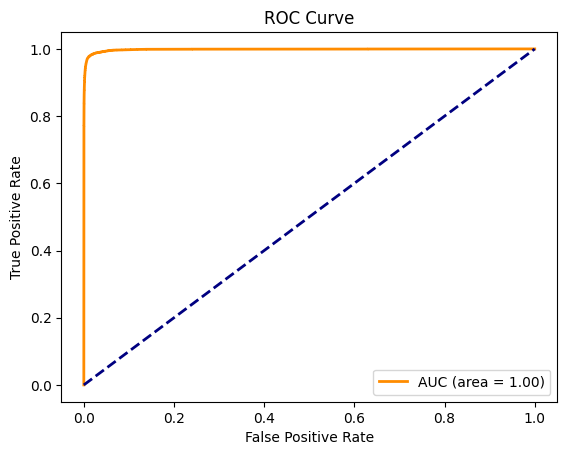

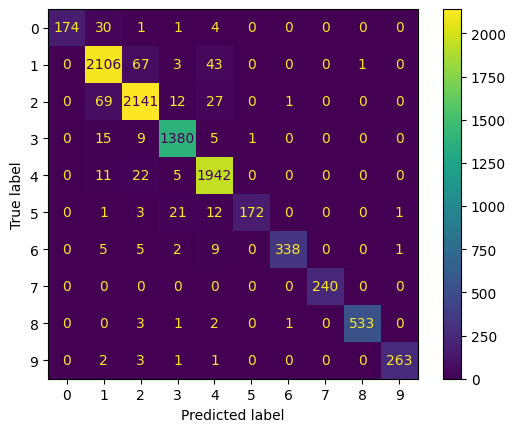

Accuracy: 0.9586171310629515
F1 Score: 0.958823617926966
Precision: 0.9591061545105048
Recall/Sensitivity/True Positive Rate: 0.9586171310629515
False Positive Rate: [0.         0.         0.         ... 0.87995643 0.87995643 1.        ]
Area under ROC curve: 0.996475515305175
Confusion Matrix:
 [[ 174   30    1    1    4    0    0    0    0    0]
 [   0 2106   67    3   43    0    0    0    1    0]
 [   0   69 2141   12   27    0    1    0    0    0]
 [   0   15    9 1380    5    1    0    0    0    0]
 [   0   11   22    5 1942    0    0    0    0    0]
 [   0    1    3   21   12  172    0    0    0    1]
 [   0    5    5    2    9    0  338    0    0    1]
 [   0    0    0    0    0    0    0  240    0    0]
 [   0    0    3    1    2    0    1    0  533    0]
 [   0    2    3    1    1    0    0    0    0  263]]


In [106]:
# testing set (normalized)
perceptron_clf_calibrated.fit(x_train_norm, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_train_norm, y_train)

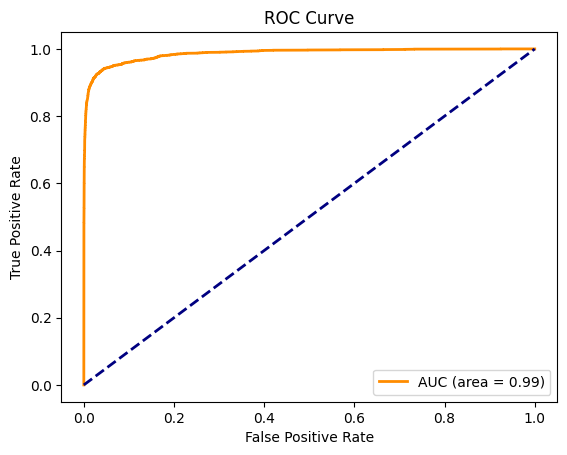

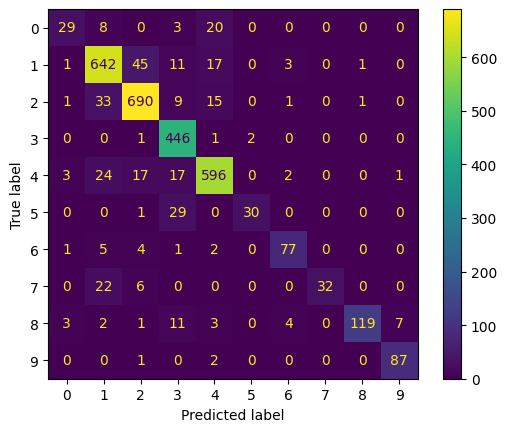

Accuracy: 0.8893203883495145
F1 Score: 0.8927535137086572
Precision: 0.8918240668164629
Recall/Sensitivity/True Positive Rate: 0.8893203883495145
False Positive Rate: [0.         0.         0.         ... 0.92477526 0.92477526 1.        ]
Area under ROC curve: 0.9804998182548255
Confusion Matrix:
 [[ 29   8   0   3  20   0   0   0   0   0]
 [  1 642  45  11  17   0   3   0   1   0]
 [  1  33 690   9  15   0   1   0   1   0]
 [  0   0   1 446   1   2   0   0   0   0]
 [  3  24  17  17 596   0   2   0   0   1]
 [  0   0   1  29   0  30   0   0   0   0]
 [  1   5   4   1   2   0  77   0   0   0]
 [  0  22   6   0   0   0   0  32   0   0]
 [  3   2   1  11   3   0   4   0 119   7]
 [  0   0   1   0   2   0   0   0   0  87]]


In [126]:
# testing set (normalized)
perceptron_clf_calibrated.fit(x_train_norm, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_test_norm, y_test)

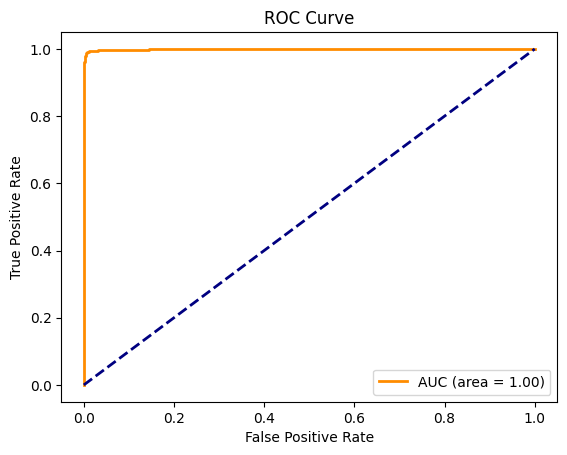

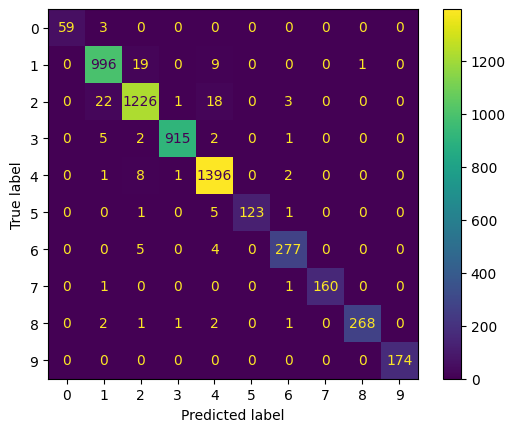

Accuracy: 0.9784852195207276
F1 Score: 0.9784857105715234
Precision: 0.9786026942438196
Recall/Sensitivity/True Positive Rate: 0.9784852195207276
False Positive Rate: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.94352127e-05
 1.94352127e-05 3.88704254e-05 3.88704254e-05 5.83056382e-05
 5.83056382e-05 7.77408509e-05 7.77408509e-05 9.71760636e-05
 9.71760636e-05 1.16611276e-04 1.16611276e-04 1.36046489e-04
 1.36046489e-04 1.55481702e-04 1.55481702e-04 1.74916914e-04
 1.74916914e-04 1.94352127e-04 1.94352127e-04 2.13787340e-04
 2.13787340e-04 2.33222553e-04 2.33222553e-04 2.52657765e-04
 2.52657765e-04 2.72092978e-04 2.72092978e-04 2.91528191e-04
 2.91528191e-04 3.10963403e-04 3.10963403e-04 3.30398616e-04
 3.30398616e-04 3.49833829e-04 3.49833829e-04 3.69269042e-04
 3.69269042e-04 3.88704254e-04 3.88704254e-04 4.08139467e-04
 4.08139467e-04 4.27574680e-04 4.27574680e-04 4.47009893e-04
 4.47009893e-04 4.66445105e-04 4.66445105e-04 4.85880318e-04
 4.85880318e-04 5.05315531e-04 5.0531553

In [127]:
# training set (normalized no outliers)
perceptron_clf_calibrated.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_train_no_outliers_norm, y_train_filtered_outlier_norm)

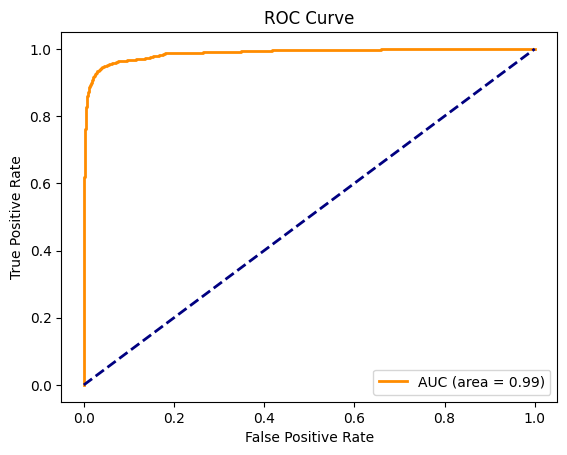

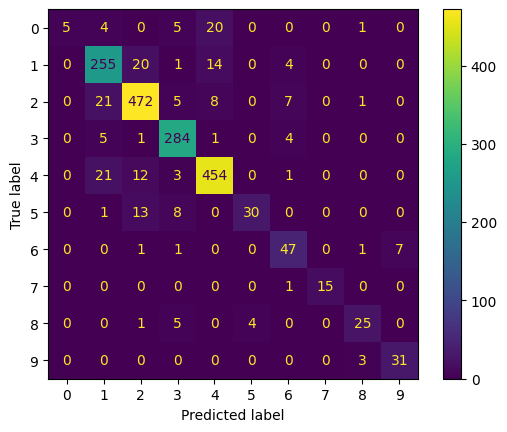

Accuracy: 0.8875479978058146
F1 Score: 0.8937897860050769
Precision: 0.8900191622397492
Recall/Sensitivity/True Positive Rate: 0.8875479978058146
False Positive Rate: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.09495947e-05
 6.09495947e-05 1.21899189e-04 1.21899189e-04 1.82848784e-04
 1.82848784e-04 2.43798379e-04 2.43798379e-04 3.04747973e-04
 3.04747973e-04 3.65697568e-04 3.65697568e-04 4.26647163e-04
 4.26647163e-04 4.87596757e-04 4.87596757e-04 5.48546352e-04
 5.48546352e-04 6.09495947e-04 6.09495947e-04 6.70445542e-04
 6.70445542e-04 7.31395136e-04 7.31395136e-04 7.92344731e-04
 7.92344731e-04 8.53294326e-04 8.53294326e-04 9.14243920e-04
 9.14243920e-04 9.75193515e-04 9.75193515e-04 1.03614311e-03
 1.03614311e-03 1.09709270e-03 1.09709270e-03 1.15804230e-03
 1.15804230e-03 1.21899189e-03 1.21899189e-03 1.27994149e-03
 1.27994149e-03 1.34089108e-03 1.34089108e-03 1.40184068e-03
 1.40184068e-03 1.52373987e-03 1.52373987e-03 1.58468946e-03
 1.58468946e-03 1.64563906e-03 1.6456390

In [128]:
# testing set (normalized no outliers)
perceptron_clf_calibrated.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_test_no_outliers_norm, y_test_filtered_outlier_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

Cross-validation accuracy scores: [0.91744066 0.94014448 0.92672859 0.92363261 0.93085655 0.9370485
 0.94014448 0.92672859 0.93085655 0.93188854]
Mean accuracy: 0.930546955624355
Accuracy standard deviation: 0.0069081807930565986


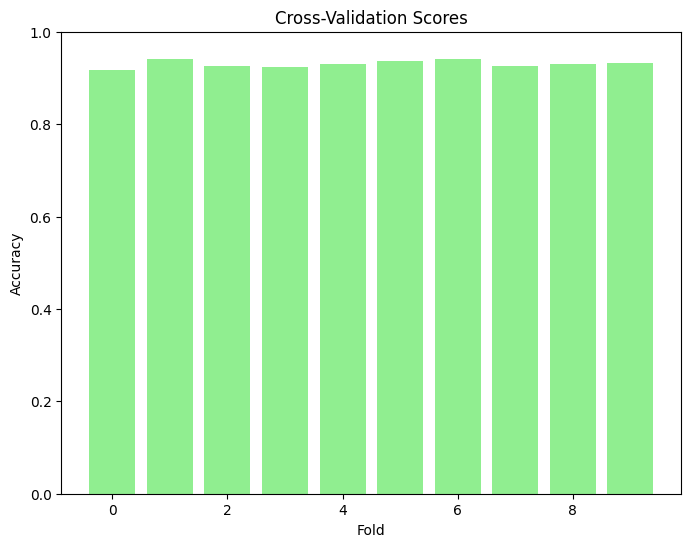

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

Overall Precision: 0.9517535374757005
Overall Recall: 0.9011540260901961
Overall F1 Score: 0.9241358680496938


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

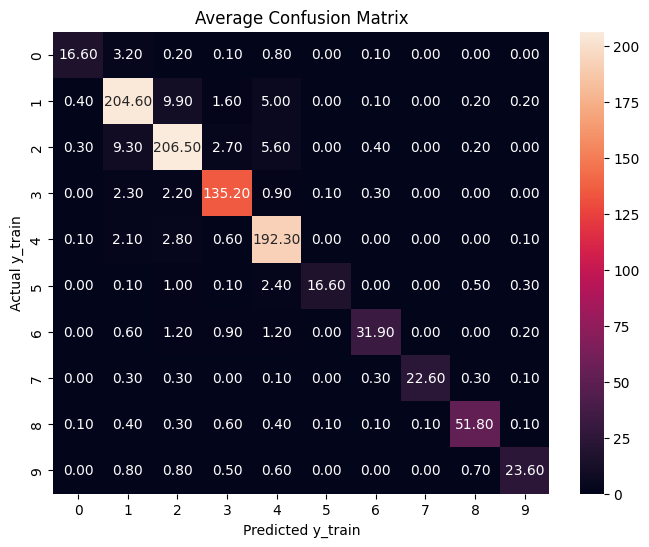

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

Overall ROC-AUC: 0.9921788000424163


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

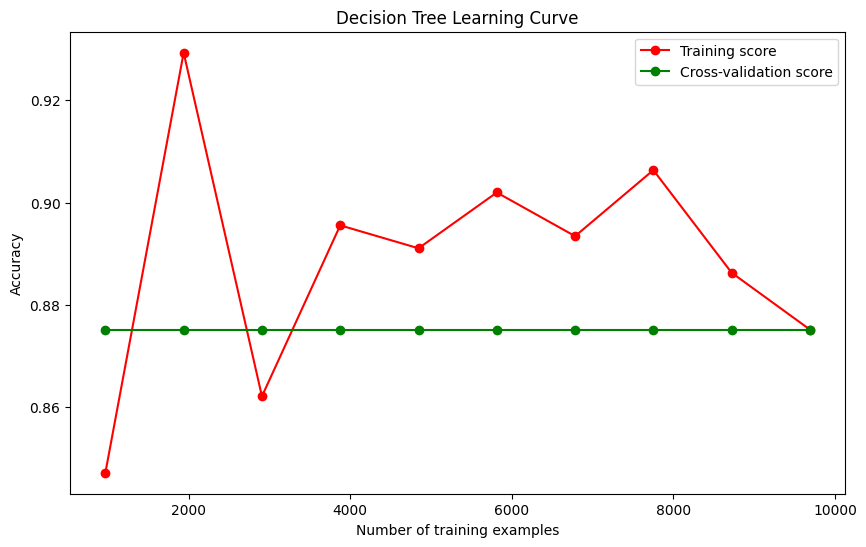

Average Training Score: 0.8888216858975696
Average Cross-Validation Score: 0.8751289989680082


In [53]:
# training set with 10-fold cross-valiation
get_cross_val_metrics(perceptron_clf_calibrated, x_train, y_train.to_numpy().ravel())
plot_learning_curve(perceptron_clf_calibrated, x_train, y_train.to_numpy().ravel())

In [129]:
from sklearn.neural_network import MLPClassifier

# baseline with default values for the hyperparameters (excl. solver, using gradient descent as done in the lectures)
mlp_clf = MLPClassifier(
    random_state=42, # save random state for reproducible results
    solver="sgd", # use (stochastic) gradient descent
    activation="relu", # activation function
    hidden_layer_sizes=(100,), # size for each hidden layer
    learning_rate_init=0.001, # initial learning rate
    max_iter=200, # no. of epochs
    momentum=0.9
)

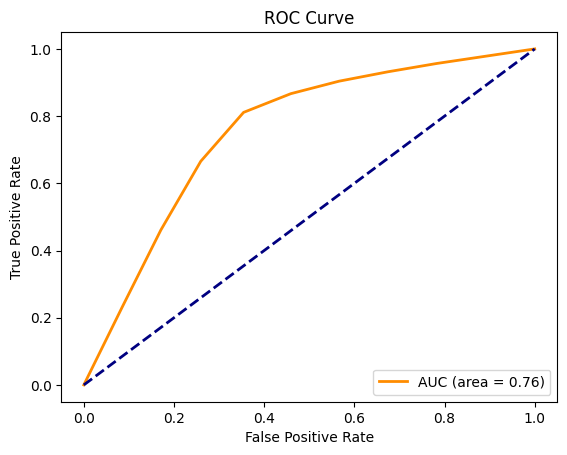

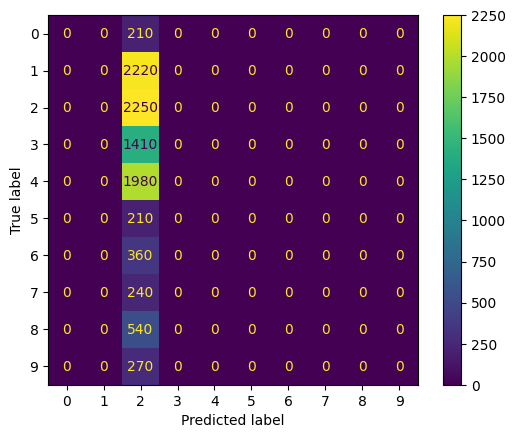

Accuracy: 0.23219814241486067
F1 Score: 0.37688442211055273
Precision: 0.8217178349260513
Recall/Sensitivity/True Positive Rate: 0.23219814241486067
False Positive Rate: [0.         0.08531132 0.17096663 0.25937393 0.35431717 0.45923633
 0.56621947 0.67423461 0.78259374 1.        ]
Area under ROC curve: 0.5
Confusion Matrix:
 [[   0    0  210    0    0    0    0    0    0    0]
 [   0    0 2220    0    0    0    0    0    0    0]
 [   0    0 2250    0    0    0    0    0    0    0]
 [   0    0 1410    0    0    0    0    0    0    0]
 [   0    0 1980    0    0    0    0    0    0    0]
 [   0    0  210    0    0    0    0    0    0    0]
 [   0    0  360    0    0    0    0    0    0    0]
 [   0    0  240    0    0    0    0    0    0    0]
 [   0    0  540    0    0    0    0    0    0    0]
 [   0    0  270    0    0    0    0    0    0    0]]


In [101]:
# testing default MLPClassifier on training set

mlp_clf.fit(x_train, y_train.to_numpy().ravel())
get_metrics(mlp_clf, x_train, y_train)

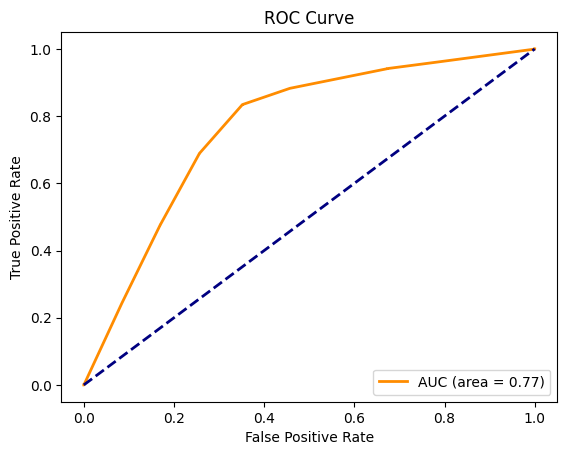

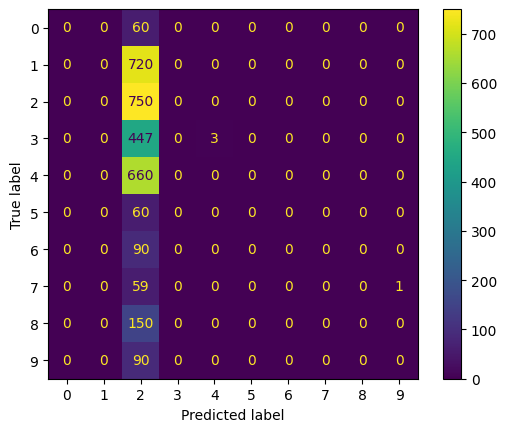

Accuracy: 0.24271844660194175
F1 Score: 0.39052613462648184
Precision: 0.5735517117706649
Recall/Sensitivity/True Positive Rate: 0.24271844660194175
False Positive Rate: [0.00000000e+00 3.59582884e-05 1.79791442e-04 8.41783531e-02
 1.69255663e-01 1.69291622e-01 2.56526429e-01 2.56598346e-01
 3.51492269e-01 3.51492269e-01 3.51708019e-01 4.57281553e-01
 4.57425387e-01 6.72887451e-01 6.72887451e-01 7.81733190e-01
 7.81769148e-01 9.99388709e-01 9.99568501e-01 9.99568501e-01
 1.00000000e+00 1.00000000e+00]
Area under ROC curve: 0.49969625403087203
Confusion Matrix:
 [[  0   0  60   0   0   0   0   0   0   0]
 [  0   0 720   0   0   0   0   0   0   0]
 [  0   0 750   0   0   0   0   0   0   0]
 [  0   0 447   0   3   0   0   0   0   0]
 [  0   0 660   0   0   0   0   0   0   0]
 [  0   0  60   0   0   0   0   0   0   0]
 [  0   0  90   0   0   0   0   0   0   0]
 [  0   0  59   0   0   0   0   0   0   1]
 [  0   0 150   0   0   0   0   0   0   0]
 [  0   0  90   0   0   0   0   0   0   0]]


In [131]:
# testing default MLPClassifier on validation set

mlp_clf.fit(x_train, y_train.to_numpy().ravel())
get_metrics(mlp_clf, x_test, y_test)

SGD did not converge.


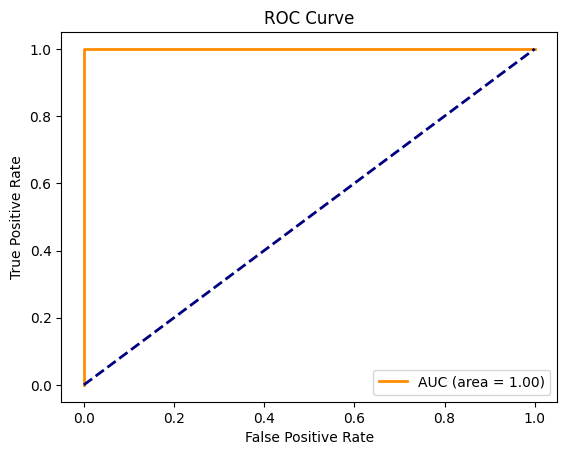

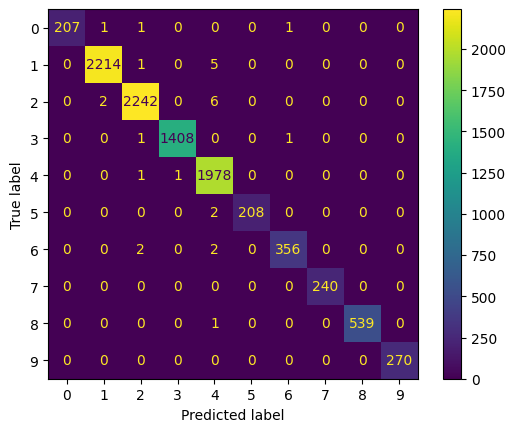

Accuracy: 0.997110423116615
F1 Score: 0.9971103588337135
Precision: 0.9971198200707179
Recall/Sensitivity/True Positive Rate: 0.997110423116615
False Positive Rate: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14665749e-05
 1.14665749e-05 2.29331499e-05 2.29331499e-05 3.43997248e-05
 3.43997248e-05 4.58662997e-05 4.58662997e-05 5.73328747e-05
 5.73328747e-05 9.17325995e-05 9.17325995e-05 1.03199174e-04
 1.03199174e-04 1.14665749e-04 1.14665749e-04 1.37598899e-04
 1.37598899e-04 1.49065474e-04 1.49065474e-04 1.60532049e-04
 1.60532049e-04 1.71998624e-04 1.71998624e-04 1.83465199e-04
 1.83465199e-04 1.94931774e-04 1.94931774e-04 2.06398349e-04
 2.06398349e-04 2.17864924e-04 2.17864924e-04 2.29331499e-04
 2.29331499e-04 2.40798074e-04 2.40798074e-04 2.63731223e-04
 2.63731223e-04 2.75197798e-04 2.75197798e-04 2.86664373e-04
 2.86664373e-04 3.21064098e-04 3.21064098e-04 3.55463823e-04
 3.55463823e-04 3.66930398e-04 3.66930398e-04 3.78396973e-04
 3.78396973e-04 3.89863548e-04 3.89863548e

In [132]:
# STOPPED RUNNING HERE

# testing default MLPClassifier on normalized training set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_train_norm, y_train)

# return to normal warning behaviour
warnings.resetwarnings()

SGD did not converge.


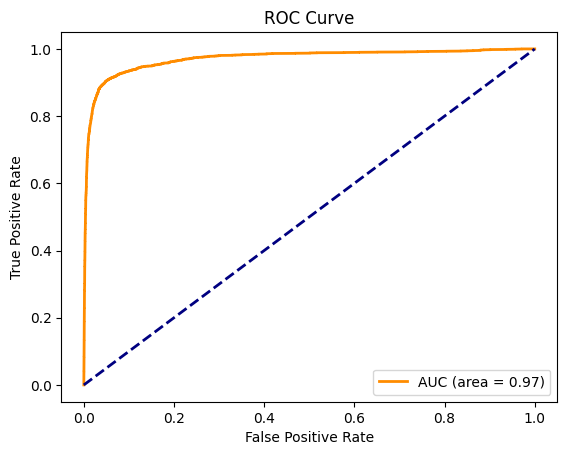

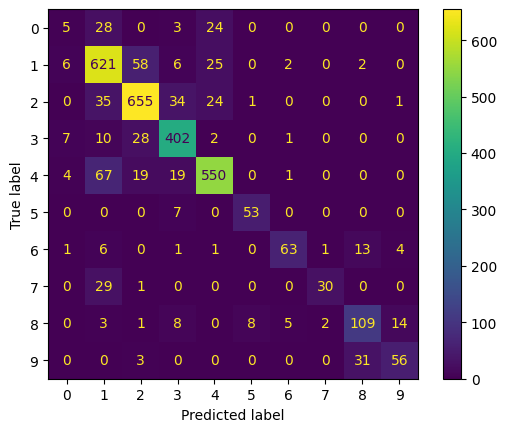

Accuracy: 0.8233009708737864
F1 Score: 0.8287491322905155
Precision: 0.8183872792708318
Recall/Sensitivity/True Positive Rate: 0.8233009708737864
False Positive Rate: [0.         0.         0.         ... 0.97116145 0.97116145 1.        ]
Area under ROC curve: 0.9618727891806784
Confusion Matrix:
 [[  5  28   0   3  24   0   0   0   0   0]
 [  6 621  58   6  25   0   2   0   2   0]
 [  0  35 655  34  24   1   0   0   0   1]
 [  7  10  28 402   2   0   1   0   0   0]
 [  4  67  19  19 550   0   1   0   0   0]
 [  0   0   0   7   0  53   0   0   0   0]
 [  1   6   0   1   1   0  63   1  13   4]
 [  0  29   1   0   0   0   0  30   0   0]
 [  0   3   1   8   0   8   5   2 109  14]
 [  0   0   3   0   0   0   0   0  31  56]]


In [133]:
# testing default MLPClassifier on normalized testing set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_test_norm, y_test)

# return to normal warning behaviour
warnings.resetwarnings()

SGD did not converge.


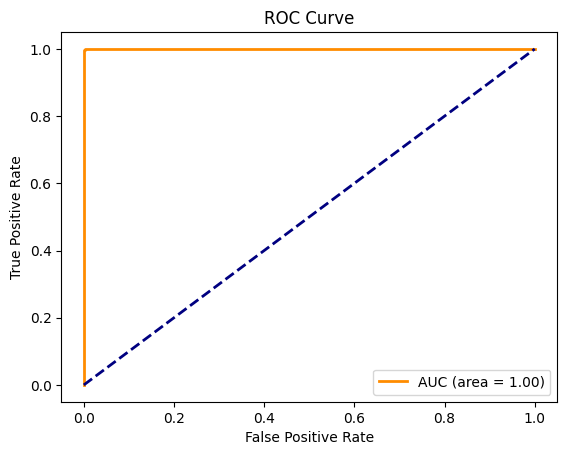

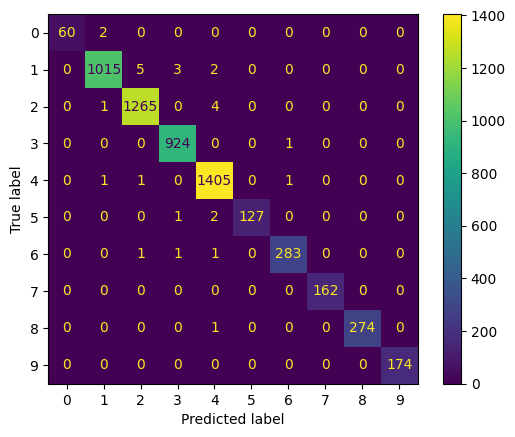

Accuracy: 0.9951023263949624
F1 Score: 0.9951079988379075
Precision: 0.9951113231997473
Recall/Sensitivity/True Positive Rate: 0.9951023263949624
Area under ROC curve: 0.9998756619643709
Confusion Matrix:
 [[  60    2    0    0    0    0    0    0    0    0]
 [   0 1015    5    3    2    0    0    0    0    0]
 [   0    1 1265    0    4    0    0    0    0    0]
 [   0    0    0  924    0    0    1    0    0    0]
 [   0    1    1    0 1405    0    1    0    0    0]
 [   0    0    0    1    2  127    0    0    0    0]
 [   0    0    1    1    1    0  283    0    0    0]
 [   0    0    0    0    0    0    0  162    0    0]
 [   0    0    0    0    1    0    0    0  274    0]
 [   0    0    0    0    0    0    0    0    0  174]]


In [136]:
# testing default MLPClassifier on normalized and outlier mined training set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)

# return to normal warning behaviour
warnings.resetwarnings()

SGD did not converge.


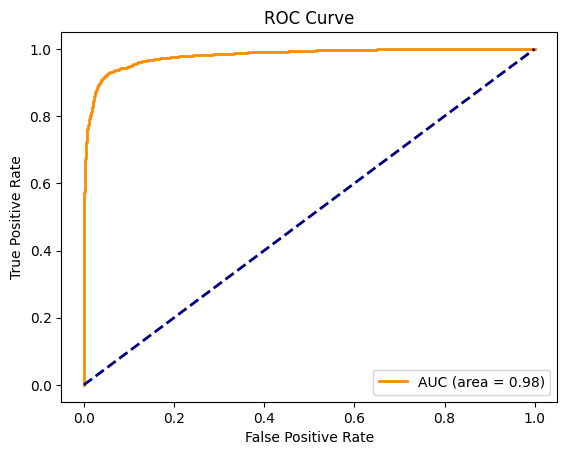

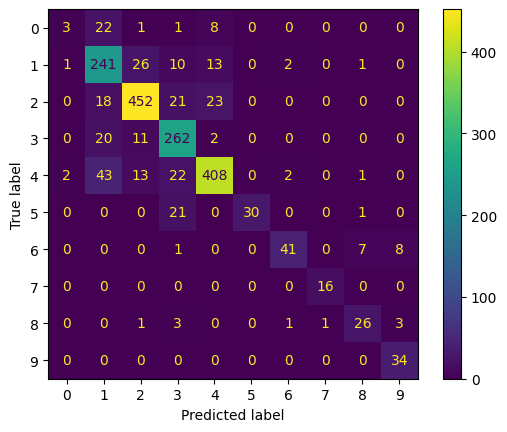

Accuracy: 0.829950630828305
F1 Score: 0.8345902367027265
Precision: 0.8344361026001998
Recall/Sensitivity/True Positive Rate: 0.829950630828305
Area under ROC curve: 0.9733994389109427
Confusion Matrix:
 [[  3  22   1   1   8   0   0   0   0   0]
 [  1 241  26  10  13   0   2   0   1   0]
 [  0  18 452  21  23   0   0   0   0   0]
 [  0  20  11 262   2   0   0   0   0   0]
 [  2  43  13  22 408   0   2   0   1   0]
 [  0   0   0  21   0  30   0   0   1   0]
 [  0   0   0   1   0   0  41   0   7   8]
 [  0   0   0   0   0   0   0  16   0   0]
 [  0   0   1   3   0   0   1   1  26   3]
 [  0   0   0   0   0   0   0   0   0  34]]


In [137]:
# testing default MLPClassifier on normalized and outlier mined testing set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_test_no_outliers_norm, y_test_filtered_outlier_norm)

# return to normal warning behaviour
warnings.resetwarnings()

Incresing the size of a layer did not have a significant increase in performance past 100 and had no significant effect on overfitting

In [140]:
# experimenting with the size of one hidden layer

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

# initialize dataframes for results
train_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
# loop over different variations of the model
i = 0
for size in [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,)]:
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation="relu",
        hidden_layer_sizes=size,
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9
    )
    # train data and specify whether gradient descent converged or not
    try:
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
    except Warning:
        print(size, "  -   SGD did not converge.")
    else:
        print(size, "  -   SGD converged!")
    train_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_train_norm, y_train)
    test_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

# display results
print("train set")
display(train_set)
print("test set")
display(test_set)

# return to normal warning behaviour
warnings.resetwarnings()

(1,)   -   SGD did not converge.
(2,)   -   SGD did not converge.
(3,)   -   SGD did not converge.
(4,)   -   SGD did not converge.
(5,)   -   SGD did not converge.
(6,)   -   SGD did not converge.
(7,)   -   SGD did not converge.
(8,)   -   SGD did not converge.
(9,)   -   SGD did not converge.
(10,)   -   SGD did not converge.
(11,)   -   SGD did not converge.
(12,)   -   SGD did not converge.
train set


,size,accuracy,f1,precision,recall,roc
0,"(1,)",0.300413,0.407386,0.641759,0.300413,0.697035
1,"(2,)",0.665635,0.707674,0.689855,0.665635,0.905807
2,"(3,)",0.709701,0.729402,0.787778,0.709701,0.942178
3,"(4,)",0.704231,0.712561,0.749389,0.704231,0.934598
4,"(5,)",0.805057,0.802847,0.823675,0.805057,0.961959
5,"(6,)",0.761713,0.767710,0.786746,0.761713,0.953284
6,"(7,)",0.810320,0.817168,0.834534,0.810320,0.960732
7,"(8,)",0.808772,0.812552,0.812724,0.808772,0.948846
8,"(9,)",0.760475,0.743714,0.809131,0.760475,0.924206
9,"(10,)",0.811352,0.810561,0.821931,0.811352,0.957867


test set


,size,accuracy,f1,precision,recall,roc
0,"(1,)",0.265696,0.361324,0.618772,0.265696,0.659341
1,"(2,)",0.612945,0.652770,0.625351,0.612945,0.876428
2,"(3,)",0.690615,0.711800,0.750775,0.690615,0.914863
3,"(4,)",0.691586,0.705298,0.698964,0.691586,0.914786
4,"(5,)",0.744660,0.746487,0.746574,0.744660,0.931043
5,"(6,)",0.707767,0.716691,0.730341,0.707767,0.918837
6,"(7,)",0.743689,0.757839,0.757653,0.743689,0.924949
7,"(8,)",0.728803,0.739540,0.713134,0.728803,0.922734
8,"(9,)",0.666019,0.652161,0.705342,0.666019,0.884499
9,"(10,)",0.736893,0.742051,0.740564,0.736893,0.922085


As the number of nodes in a layer increases, the accuracy increases. However, as shown by the large difference between the training and testing sets n >= 4, too many nodes leads to overfitting

In [13]:
# experimenting with epochs and different sizes for a hidden layer

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["epochs", "size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["epochs", "size", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for epochs in [150, 300, 450]:
    for size in [(2,), (6,), (12,)]:
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=size,
            learning_rate_init=0.001,
            max_iter=epochs,
            momentum=0.9
        )
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        train_set.loc[i] = [str(epochs), str(size)] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [str(epochs), str(size)] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimiza

train set


,epochs,size,accuracy,f1,precision,recall,roc
0,150,"(2,)",0.694118,0.779689,0.665350,0.694118,0.938979
1,150,"(6,)",0.915686,0.923957,0.913971,0.915686,0.995838
2,150,"(12,)",0.973271,0.973394,0.973448,0.973271,0.998935
3,300,"(2,)",0.702374,0.788005,0.793205,0.702374,0.943806
4,300,"(6,)",0.967389,0.967556,0.967311,0.967389,0.998428
5,300,"(12,)",0.989370,0.989369,0.989440,0.989370,0.999726
6,450,"(2,)",0.721569,0.794628,0.816008,0.721569,0.945605
7,450,"(6,)",0.978225,0.978280,0.978214,0.978225,0.999167
8,450,"(12,)",0.995666,0.995665,0.995675,0.995666,0.999877


test set


,epochs,size,accuracy,f1,precision,recall,roc
0,150,"(2,)",0.660518,0.738756,0.774232,0.660518,0.908109
1,150,"(6,)",0.823301,0.840500,0.814766,0.823301,0.961100
2,150,"(12,)",0.862783,0.867672,0.863384,0.862783,0.965998
3,300,"(2,)",0.666343,0.746735,0.747208,0.666343,0.907589
4,300,"(6,)",0.844660,0.850638,0.838800,0.844660,0.964678
5,300,"(12,)",0.867638,0.871385,0.867565,0.867638,0.967273
6,450,"(2,)",0.669579,0.741959,0.749294,0.669579,0.906726
7,450,"(6,)",0.852751,0.857375,0.848087,0.852751,0.966685
8,450,"(12,)",0.862460,0.866304,0.860648,0.862460,0.966864


As shown above, increasing the number of epochs increases accuracy, but once again, a very large number leads to overfitting.
Despite increasing the number of epochs, optimization still does not converge, indicating the need for regularization and a different/varying learning rate

In [27]:
# experimenting with different learning rates and alpha values

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["lr", "alpha", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["lr", "alpha", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for lr in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
# for lr in [0.005, 0.01, 0.05, 0.1, 0.5]:
    for alpha in (10.0**-np.arange(1,7)):
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=(3,),
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=200,
            momentum=0.9
        )
        try:
            mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
        except Warning:
            print(lr, alpha, "  -   SGD did not converge.")
        else:
            print(lr, alpha, "  -   SGD converged!.")
        train_set.loc[i] = [lr, alpha] + get_metrics_array(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)
        test_set.loc[i] = [lr, alpha] + get_metrics_array(mlp_clf, x_test_no_outliers_norm, y_test_filtered_outlier_norm)
        i += 1

print("train set")
display(train_set)  
print("test set")
display(test_set)

warnings.resetwarnings()

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

train set


,lr,alpha,accuracy,f1,precision,recall,roc
0,0.0001,0.100000,0.471226,0.564257,0.614918,0.471226,0.885260
1,0.0001,0.010000,0.471751,0.564919,0.615224,0.471751,0.885313
2,0.0001,0.001000,0.471751,0.564922,0.615221,0.471751,0.885322
3,0.0001,0.000100,0.471751,0.564960,0.615171,0.471751,0.885325
4,0.0001,0.000010,0.471751,0.564922,0.615221,0.471751,0.885317
5,0.0001,0.000001,0.471751,0.564922,0.615221,0.471751,0.885315
6,0.0005,0.100000,0.766661,0.810443,0.801856,0.766661,0.977696
7,0.0005,0.010000,0.767011,0.810820,0.803132,0.767011,0.977740
8,0.0005,0.001000,0.767361,0.811147,0.803590,0.767361,0.977751
9,0.0005,0.000100,0.766836,0.810608,0.802985,0.766836,0.977756


test set


,lr,alpha,accuracy,f1,precision,recall,roc
0,0.0001,0.100000,0.417799,0.491451,0.648672,0.417799,0.733669
1,0.0001,0.010000,0.418447,0.492333,0.648938,0.418447,0.733897
2,0.0001,0.001000,0.418447,0.492333,0.648938,0.418447,0.733894
3,0.0001,0.000100,0.418447,0.492398,0.648823,0.418447,0.733909
4,0.0001,0.000010,0.418447,0.492333,0.648938,0.418447,0.733899
5,0.0001,0.000001,0.418447,0.492333,0.648938,0.418447,0.733907
6,0.0005,0.100000,0.644984,0.680657,0.691001,0.644984,0.891648
7,0.0005,0.010000,0.644984,0.681040,0.687198,0.644984,0.891787
8,0.0005,0.001000,0.644337,0.680242,0.686920,0.644337,0.891782
9,0.0005,0.000100,0.644660,0.680661,0.687000,0.644660,0.891736


A very low learning rate led to lower accuracies, indicating that there were not enough epochs to approach the minimum with such a low learning rate. A very high learning rate resulted in even lower accuracies, indicating that the algorithm overshot the minumum and was diverging. changing alpha (regularization strength had a minimal effect on the results)

In [103]:
# experimenting with constant and varying learning rates

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["learning rate", "size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["learning rate", "size", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for lr in ["constant", "adaptive", "invscaling"]:
    for size in [(2,), (3,), (4,), (5,), (6,)]:
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=size,
            learning_rate=lr,
            max_iter=200,
            momentum=0.9
        )
        # mlp_clf.fit(x, y_train_filtered_outlier_norm.to_numpy().ravel())
        # train_set.loc[i] = [lr, size] + get_metrics_array(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)
        try:
            mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        except Warning:
            print(str(lr) + ",", size, "  -   SGD did not converge.")
        else:
            print(str(lr) + ",", size, "  -   SGD converged!")
        train_set.loc[i] = [lr, size] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [lr, size] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

constant, (2,)   -   SGD did not converge.
constant, (3,)   -   SGD did not converge.
constant, (4,)   -   SGD did not converge.
constant, (5,)   -   SGD did not converge.
constant, (6,)   -   SGD did not converge.
adaptive, (2,)   -   SGD did not converge.
adaptive, (3,)   -   SGD did not converge.
adaptive, (4,)   -   SGD did not converge.
adaptive, (5,)   -   SGD did not converge.
adaptive, (6,)   -   SGD did not converge.
invscaling, (2,)   -   SGD did not converge.
invscaling, (3,)   -   SGD did not converge.
invscaling, (4,)   -   SGD converged!
invscaling, (5,)   -   SGD did not converge.
invscaling, (6,)   -   SGD did not converge.
train set


,learning rate,size,accuracy,f1,precision,recall,roc
0,constant,"(2,)",0.696388,0.783717,0.740060,0.696388,0.941852
1,constant,"(3,)",0.855521,0.886455,0.878088,0.855521,0.986914
2,constant,"(4,)",0.881527,0.906662,0.889977,0.881527,0.990715
3,constant,"(5,)",0.905057,0.921259,0.911176,0.905057,0.995373
4,constant,"(6,)",0.941383,0.943626,0.939801,0.941383,0.997158
5,adaptive,"(2,)",0.696388,0.783717,0.740060,0.696388,0.941852
6,adaptive,"(3,)",0.855521,0.886455,0.878088,0.855521,0.986914
7,adaptive,"(4,)",0.881527,0.906662,0.889977,0.881527,0.990715
8,adaptive,"(5,)",0.905057,0.921259,0.911176,0.905057,0.995373
9,adaptive,"(6,)",0.941383,0.943626,0.939801,0.941383,0.997158


test set


,learning rate,size,accuracy,f1,precision,recall,roc
0,constant,"(2,)",0.664078,0.744109,0.774467,0.664078,0.908133
1,constant,"(3,)",0.807120,0.836758,0.843734,0.807120,0.952550
2,constant,"(4,)",0.791909,0.816204,0.773248,0.791909,0.951564
3,constant,"(5,)",0.820388,0.839191,0.803389,0.820388,0.962237
4,constant,"(6,)",0.831068,0.840361,0.822008,0.831068,0.961844
5,adaptive,"(2,)",0.664078,0.744109,0.774467,0.664078,0.908133
6,adaptive,"(3,)",0.807120,0.836758,0.843734,0.807120,0.952550
7,adaptive,"(4,)",0.791909,0.816204,0.773248,0.791909,0.951564
8,adaptive,"(5,)",0.820388,0.839191,0.803389,0.820388,0.962237
9,adaptive,"(6,)",0.831068,0.840361,0.822008,0.831068,0.961844


In [37]:
# experimenting with different numbers of layers and sizes of said layers

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for size in [(3,), (3, 3), (3, 3, 3), (3, 3, 3, 3), (3, 3, 3, 3, 3), (10,), (10, 10), (10, 10, 10)]:
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation="relu",
        hidden_layer_sizes=size,
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9
    )
    try:
        mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
    except Warning:
        print(size, "  -   SGD did not converge.")
    else:
        print(size, "  -   SGD converged!")
    train_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)
    test_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

(3,)   -   SGD did not converge.
(3, 3)   -   SGD did not converge.
(3, 3, 3)   -   SGD did not converge.
(3, 3, 3, 3)   -   SGD did not converge.
(3, 3, 3, 3, 3)   -   SGD did not converge.
(10,)   -   SGD did not converge.
(10, 10)   -   SGD did not converge.
(10, 10, 10)   -   SGD did not converge.
train set


,size,accuracy,f1,precision,recall,roc
0,"(3,)",0.829281,0.854433,0.882242,0.829281,0.986720
1,"(3, 3)",0.779605,0.811059,0.876740,0.779605,0.971192
2,"(3, 3, 3)",0.751618,0.818731,0.841892,0.751618,0.971241
3,"(3, 3, 3, 3)",0.697569,0.767555,0.763827,0.697569,0.923282
4,"(3, 3, 3, 3, 3)",0.790275,0.832895,0.815955,0.790275,0.978532
5,"(10,)",0.982683,0.982721,0.982693,0.982683,0.999143
6,"(10, 10)",0.976386,0.977019,0.976281,0.976386,0.999190
7,"(10, 10, 10)",0.991079,0.991109,0.991077,0.991079,0.999653


test set


,size,accuracy,f1,precision,recall,roc
0,"(3,)",0.690615,0.711800,0.750775,0.690615,0.914863
1,"(3, 3)",0.619417,0.649725,0.706607,0.619417,0.865531
2,"(3, 3, 3)",0.631392,0.687643,0.709085,0.631392,0.885249
3,"(3, 3, 3, 3)",0.585437,0.639569,0.651844,0.585437,0.799082
4,"(3, 3, 3, 3, 3)",0.638835,0.668206,0.671026,0.638835,0.880971
5,"(10,)",0.736893,0.742051,0.740564,0.736893,0.922085
6,"(10, 10)",0.649191,0.645855,0.668513,0.649191,0.883250
7,"(10, 10, 10)",0.694175,0.695782,0.695702,0.694175,0.895217


In [34]:
# experimenting with different activation functions

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["activation", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["activation", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for activation in ["identity", "logistic", "tanh", "relu"]:
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation=activation,
        hidden_layer_sizes=(3,),
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9
    )
    try:
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
    except Warning:
        print(activation, "  -   SGD did not converge.")
    else:
        print(activation, "  -   SGD converged!")
    train_set.loc[i] = [activation] + get_metrics_array(mlp_clf, x_train_norm, y_train)
    test_set.loc[i] = [activation] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

SGD did not converge.
SGD did not converge.
SGD did not converge.
SGD did not converge.
train set


,activation,accuracy,f1,precision,recall,roc
0,identity,0.929618,0.930252,0.929511,0.929618,0.994216
1,logistic,0.782353,0.826156,0.841971,0.782353,0.963756
2,tanh,0.865015,0.886961,0.877096,0.865015,0.980138
3,relu,0.855521,0.886455,0.878088,0.855521,0.986914


test set


,activation,accuracy,f1,precision,recall,roc
0,identity,0.826537,0.830000,0.824536,0.826537,0.958697
1,logistic,0.713269,0.749560,0.773068,0.713269,0.924221
2,tanh,0.798382,0.816293,0.813373,0.798382,0.951674
3,relu,0.807120,0.836758,0.843734,0.807120,0.952550


relu has the smallest difference between the traing and testing sets, indication it leads to less overfitting, while at the sime time not having the lowest accuracy

In [32]:
# experimenting with different momentum values and methods (nesterov/standard)

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["nesterov", "momentum", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["nesterov", "momentum", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for nesterovs in [False, True]:
    for momentum in [0.2, 0.4, 0.5, 0.6, 0.8, 0.9]:
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=(3,),
            learning_rate_init=0.001,
            max_iter=200,
            momentum=momentum,
            nesterovs_momentum=nesterovs
        )
        try:
            mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        except Warning:
            print(nesterovs, momentum, "  -   SGD did not converge.")
        else:
            print(nesterovs, momentum, "  -   SGD converged!")
        train_set.loc[i] = [nesterovs, momentum] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [nesterovs, momentum] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

train set


,nesterov,momentum,accuracy,f1,precision,recall,roc
0,False,0.2,0.637461,0.682191,0.710667,0.637461,0.922744
1,False,0.4,0.694530,0.742990,0.770052,0.694530,0.947471
2,False,0.5,0.704025,0.762835,0.785754,0.704025,0.958648
3,False,0.6,0.729515,0.796103,0.815385,0.729515,0.968920
4,False,0.8,0.816512,0.862802,0.838317,0.816512,0.982412
5,True,0.2,0.637874,0.682570,0.711237,0.637874,0.922757
6,True,0.4,0.694221,0.742661,0.769599,0.694221,0.947710
7,True,0.5,0.704541,0.763464,0.786185,0.704541,0.958964
8,True,0.6,0.731063,0.797878,0.816490,0.731063,0.968760
9,True,0.8,0.816925,0.862566,0.840644,0.816925,0.981724


test set


,nesterov,momentum,accuracy,f1,precision,recall,roc
0,False,0.2,0.604531,0.644671,0.669590,0.604531,0.875717
1,False,0.4,0.675081,0.718653,0.738214,0.675081,0.908167
2,False,0.5,0.700647,0.747231,0.767285,0.700647,0.924259
3,False,0.6,0.715210,0.772600,0.789089,0.715210,0.937839
4,False,0.8,0.794498,0.837261,0.812055,0.794498,0.948954
5,True,0.2,0.605825,0.645967,0.671096,0.605825,0.875789
6,True,0.4,0.677346,0.721042,0.740886,0.677346,0.908713
7,True,0.5,0.703560,0.750401,0.770444,0.703560,0.924796
8,True,0.6,0.716828,0.774623,0.789456,0.716828,0.937442
9,True,0.8,0.786731,0.829135,0.802492,0.786731,0.947496


In [38]:
# experimenting with different tolerance values

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["tol", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["tol", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for tol in (10.0**-np.arange(1,7)):
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation="relu",
        hidden_layer_sizes=(3,),
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9,
        tol=tol
    )
    try:
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
    except Warning:
        print(tol, "  -   SGD did not converge.")
    else:
        print(tol, "  -   SGD converged!")
    train_set.loc[i] = [tol] + get_metrics_array(mlp_clf, x_train_norm, y_train)
    test_set.loc[i] = [tol] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

0.1   -   SGD converged!
0.01   -   SGD converged!
0.001   -   SGD did not converge.
0.0001   -   SGD did not converge.
1e-05   -   SGD did not converge.
1e-06   -   SGD did not converge.
train set


,tol,accuracy,f1,precision,recall,roc
0,0.100000,0.561713,0.610573,0.626164,0.561713,0.886442
1,0.010000,0.740041,0.807842,0.823010,0.740041,0.972811
2,0.001000,0.855521,0.886455,0.878088,0.855521,0.986914
3,0.000100,0.855521,0.886455,0.878088,0.855521,0.986914
4,0.000010,0.855521,0.886455,0.878088,0.855521,0.986914
5,0.000001,0.855521,0.886455,0.878088,0.855521,0.986914


test set


,tol,accuracy,f1,precision,recall,roc
0,0.100000,0.555663,0.597716,0.615620,0.555663,0.831728
1,0.010000,0.732039,0.791388,0.800242,0.732039,0.941835
2,0.001000,0.807120,0.836758,0.843734,0.807120,0.952550
3,0.000100,0.807120,0.836758,0.843734,0.807120,0.952550
4,0.000010,0.807120,0.836758,0.843734,0.807120,0.952550
5,0.000001,0.807120,0.836758,0.843734,0.807120,0.952550


With a tol of 0.01, the algorithm finally converges. It has a lowr accuracy but less overfitting, likely because it doesless iterations (epochs) and therefor does not learn the training data as thoroughly

Experimenting with different parameters is a time consuming process, and dealing with every possible combination of parameters is unfeasable. A systematic and automated approach to finding the best combination of parameters is GridSearchCV. We can use the results of our previous experimentation to exclude redundant values from the gridseaerch (e.g., a very high learning rate)

In [104]:
# wrap MLPClassifier in GridSearchCV

from sklearn.model_selection import GridSearchCV

def mlp_grid_search(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    y_train = y_train.to_numpy().ravel()
    # y_test = y_test.to_numpy().ravel()

    # dictionary of parameters to be varied (keys), and arrays of possible values (values)
    param_grid = {
        # number of layers and their sizes
        "hidden_layer_sizes": [(3,), (6,), (9,), (12,), (3, 3), (6, 3), (9, 6)],
        # activation functions
        "activation": ["identity", "logistic", "tanh", "relu"],
        # learning rate
        "learning_rate_init": [0.001, 0.005],
        # max number of epochs
        "max_iter": [200, 300],
        # momentum
        "momentum": [0.7, 0.8, 0.9],
        # tolerance
        "tol": [0.01, 0.001, 0.0001]
    }

    new_clf = GridSearchCV(estimator=clf, param_grid=param_grid)

In [ ]:
# perform gridsearch

# initialize classifier for grid search
mlp_clf = MLPClassifier(
    random_state=42,
    solver="sgd"
)

# get best classifier (with gridsearch results)
gs_clf = mlp_grid_search(mlp_clf, x_train_norm, y_train)

# train classifier
gs_clf.fit(x_train_norm, y_test)

In [ ]:
# get gridsearch best model results
get_metrics(gs_clf, x_test_norm, y_test)

In [ ]:
# CNNs
# theres no cnn in scikit, gotta use tensorflow (keras)
# https://www.tensorflow.org/tutorials/images/cnn

from keras import datasets, layers, models

model = models.Sequential()

# example
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))